joint_decomp.py optionally saves the ranks of the last DistMult evaluation on the validation set. Here I reload the dictionary and visualize how well the model does on entities that occur rarely in the dataset. 

In [1]:
%matplotlib inline
import numpy as np
from collections import Counter
import pandas as pd
import pickle
import matplotlib
import matplotlib.pyplot as plt

In [2]:
def make_boxplot(kgpath, evalfile, bins):
    trainset = kgpath + '/train.txt'
    validset = kgpath + '/valid.txt'
    
    # Count how many time each entity and relation occurs in training data
    entcounter = Counter()
    with open(trainset, "r") as f:
        for line in f:
            e1, r, e2 = line.strip().split()
            entcounter.update([e1, r, e2])
    
    # make a dictionary with tuples, the frequencies of their subjects and the frequencies of their objects.
    freqdict = {'tuple': [], 'subj_freq': [], 'obj_freq': [], 'rel_freq': []}
    with open(validset, "r") as f:
        for line in f:
            e1, r, e2 = line.strip().split()
            freqdict['tuple'].append((e1, r, e2))
            freqdict['subj_freq'].append(entcounter[e1])
            freqdict['obj_freq'].append(entcounter[e2])
            freqdict['rel_freq'].append(entcounter[r])

    eval_dict = pickle.load(open(evalfile,"rb"))
    
    freqs_df = pd.DataFrame(freqdict)
    ranks_df = pd.DataFrame(eval_dict)
    assert (freqs_df['tuple'] == ranks_df['tuple']).all()
    master_df = pd.merge(freqs_df, ranks_df)
    
    master_df['obj_recip_rank'] = 1/master_df['obj_rank']
    master_df['subj_recip_rank'] = 1/master_df['subj_rank']
    master_df['mean_rank'] = (master_df['obj_rank'] + master_df['subj_rank'])/2
    master_df['mean_recip_rank'] = (master_df['obj_recip_rank'] + master_df['subj_recip_rank'])/2
    master_df['min_freq'] = pd.DataFrame([master_df['obj_freq'], master_df['subj_freq']]).min()
    master_df['min_freq_discrete'] = pd.qcut(master_df['min_freq'], bins)
    
    master_df.boxplot(column='mean_rank', by='min_freq_discrete', figsize=(20,10))
    
    return master_df
    

# FB15K-237

### Vanilla DistMult

In [3]:
# Overall results
pickle.load(open("data-to-plot/FB15K-237_distmult/valid_results.pickle", "rb"))

{'hits@1': 0.21154833190761907,
 'hits@10': 0.46649558026804105,
 'hits@3': 0.32201311662390075,
 'mrr': 0.2960180848848825}

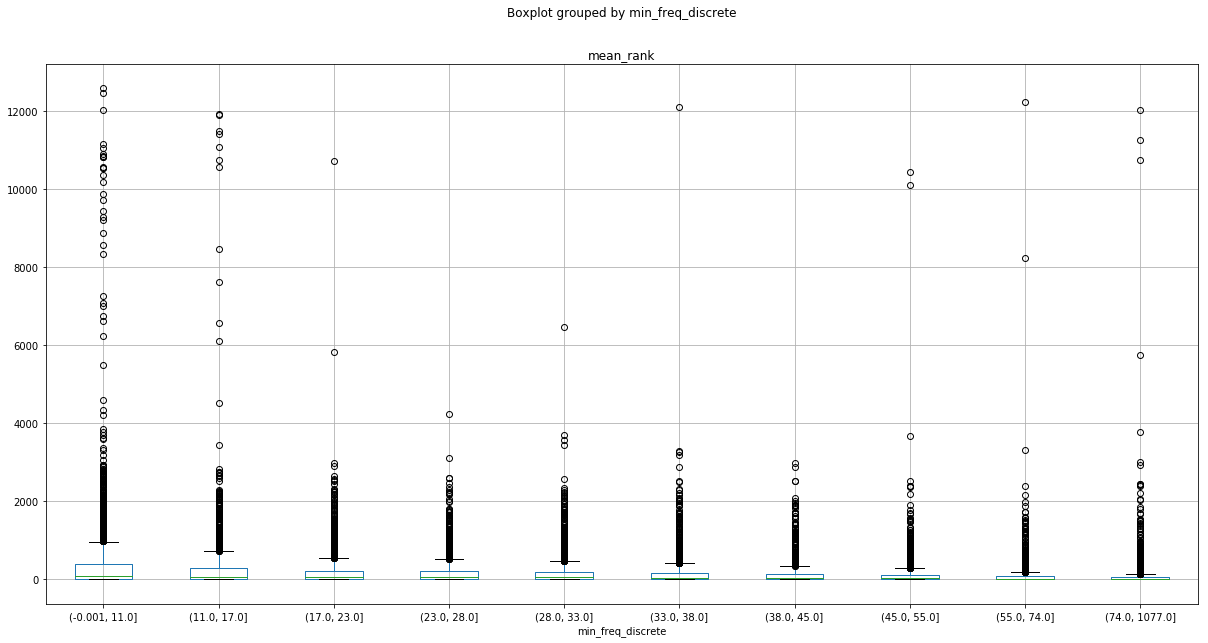

In [4]:
#Plot vanilla DistMult results for FB15K-237
kgpath = "data/FB15K-237"
evalfile = "data-to-plot/FB15K-237_distmult/fine_grained_eval.pickle"
master_df = make_boxplot(kgpath, evalfile, 10)

In [5]:
frequency_groups = master_df.groupby(by="min_freq_discrete")
frequency_groups['mean_rank'].describe()
#frequency_groups['mean_recip_rank'].describe()

,count,mean,std,min,25%,50%,75%,max
min_freq_discrete,,,,,,,,
"(-0.001, 11.0]",1845.0,496.524119,1314.038226,1.0,17.5,87.50,399.000,12570.5
"(11.0, 17.0]",1717.0,325.482819,909.167869,1.0,11.5,66.00,296.000,11923.0
"(17.0, 23.0]",1896.0,221.320939,473.970767,1.0,11.0,60.50,224.750,10704.0
"(23.0, 28.0]",1756.0,202.890945,365.706964,1.0,13.5,61.75,216.125,4223.5
"(28.0, 33.0]",1733.0,207.867859,412.046699,1.0,14.0,61.00,193.500,6461.0
"(33.0, 38.0]",1724.0,186.779002,461.192922,1.0,11.0,48.00,170.625,12105.5
"(38.0, 45.0]",1630.0,153.608589,309.172646,1.0,9.0,40.50,146.000,2990.0
"(45.0, 55.0]",1784.0,139.068105,434.490619,1.0,8.5,34.00,120.125,10423.0
"(55.0, 74.0]",1719.0,114.383362,426.656256,1.0,7.0,22.00,77.500,12218.0


### Joint DistMult-Glove

In [6]:
#Overall results
results = pickle.load(open("data-to-plot/FB15K-237_joint/valid_results.pickle", "rb"))
{key:results[key][-1] for key in results}

{'hits@1': 0.21032221271742801,
 'hits@10': 0.4619332763045395,
 'hits@3': 0.32226974622184773,
 'mrr': 0.29426498385638816}

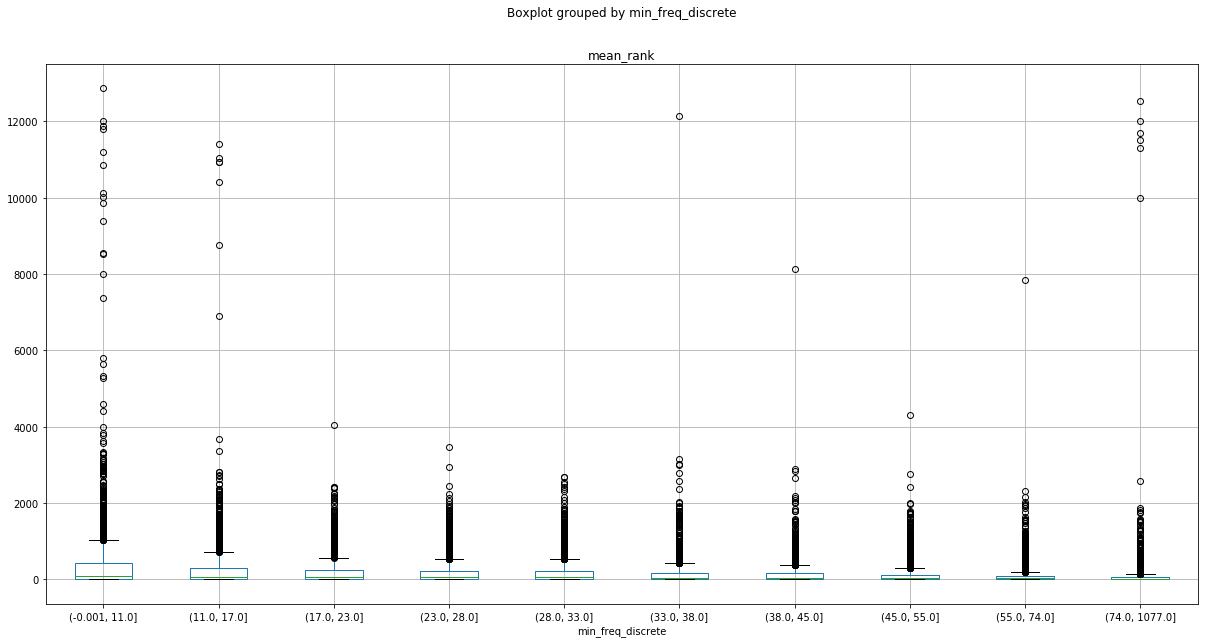

In [7]:
#Plot joint DistMult results for FB15K-237
kgpath = "data/FB15K-237"
evalfile = "data-to-plot/FB15K-237_joint/fine_grained_eval.pickle"
master_df = make_boxplot(kgpath, evalfile, 10)

In [22]:
frequency_groups = master_df.groupby(by="min_freq_discrete")
frequency_groups['mean_rank'].describe()

,count,mean,std,min,25%,50%,75%,max
min_freq_discrete,,,,,,,,
"(-0.001, 11.0]",1845.0,449.865312,1088.811070,1.0,20.500,95.50,422.000,12860.5
"(11.0, 17.0]",1717.0,300.312755,776.739493,1.0,12.500,75.50,293.000,11416.0
"(17.0, 23.0]",1896.0,213.592036,371.638113,1.0,13.000,62.75,236.750,4050.5
"(23.0, 28.0]",1756.0,210.899487,353.235998,1.0,16.875,72.00,226.750,3460.0
"(28.0, 33.0]",1733.0,204.831218,344.821089,1.0,15.500,66.00,220.000,2682.5
"(33.0, 38.0]",1724.0,181.625000,438.645872,1.0,13.000,48.50,175.000,12130.0
"(38.0, 45.0]",1630.0,155.922086,349.963162,1.0,10.500,46.00,155.000,8130.5
"(45.0, 55.0]",1784.0,133.588845,282.408313,1.0,9.500,36.00,124.125,4310.0
"(55.0, 74.0]",1719.0,114.662885,311.159739,1.0,7.500,24.00,83.250,7838.5


### Discussion
It seems like there is something that is working better: If you look at the rarest %20 entities, their mean rank is lower in the joint than in the vanilla. However, the median rank is always better for the vanilla one. This suggests that there are a few rare entities that the model ranks catastrophically low, which the joint model fixes. However the price to pay is reduced performance on the other ones. 

# YAGO3-10

### Vanilla DistMult


In [8]:
#Overall results
pickle.load(open("data-to-plot/YAGO3-10_distmult/valid_results.pickle", "rb"))

{'hits@1': 0.29360000000002,
 'hits@10': 0.57010000000002,
 'hits@3': 0.44200000000002004,
 'mrr': 0.3895380745641902}

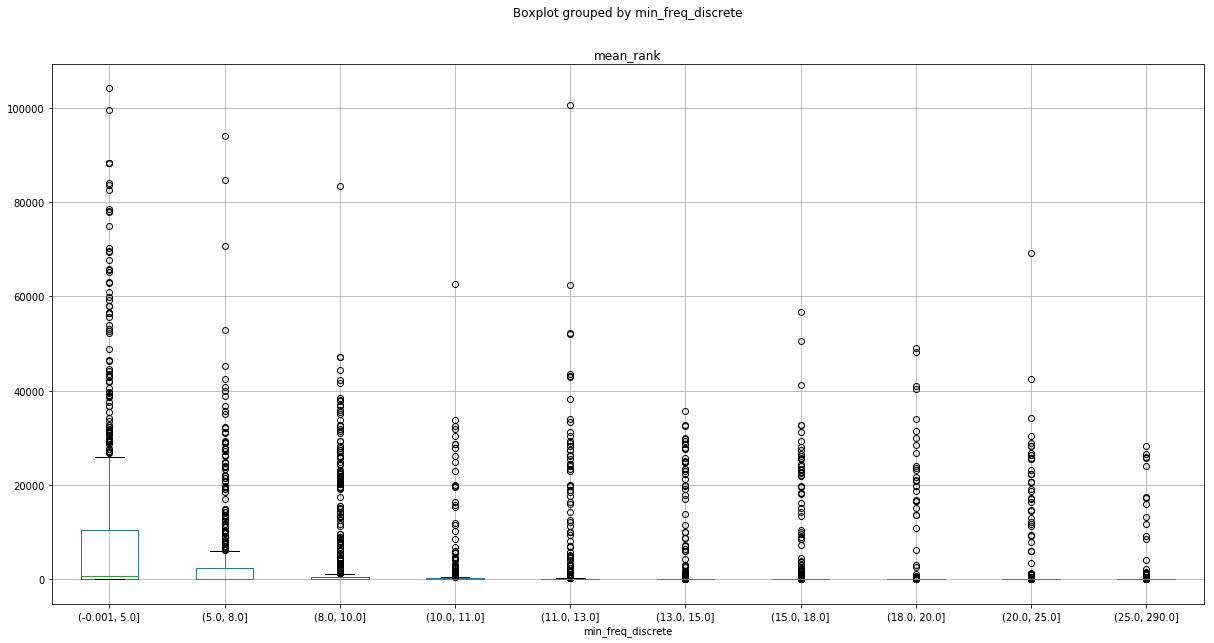

In [9]:
kgpath = "data/YAGO-mapped"
evalfile = "data-to-plot/YAGO3-10_distmult/fine_grained_eval.pickle"
master_df = make_boxplot(kgpath, evalfile, 10)

In [33]:
frequency_groups = master_df.groupby(by="min_freq_discrete")
frequency_groups['mean_rank'].describe()

,count,mean,std,min,25%,50%,75%,max
min_freq_discrete,,,,,,,,
"(-0.001, 5.0]",569.0,10149.502636,18780.861762,1.0,34.0,686.00,10425.00,104121.5
"(5.0, 8.0]",501.0,4094.068862,10256.961003,1.0,8.5,169.50,2450.00,94077.0
"(8.0, 10.0]",681.0,3260.599853,8841.969801,1.0,2.5,30.00,513.00,83525.0
"(10.0, 11.0]",312.0,1919.299679,6682.847930,1.0,2.0,6.50,194.25,62727.5
"(11.0, 13.0]",547.0,2347.326325,8698.500105,1.0,2.0,6.00,95.50,100516.0
"(13.0, 15.0]",487.0,1671.334702,5909.128336,1.0,1.5,4.00,33.00,35738.5
"(15.0, 18.0]",590.0,1529.244915,6171.037037,1.0,1.5,3.50,12.00,56660.0
"(18.0, 20.0]",324.0,1980.251543,7261.002630,1.0,1.5,3.50,12.50,49143.5
"(20.0, 25.0]",522.0,1520.654215,6235.439663,1.0,1.5,3.25,8.50,69201.0


### Joint

In [36]:
results = pickle.load(open("data-to-plot/YAGO3-10_joint/valid_results.pickle", "rb"))
{key:results[key][-1] for key in results}

{'mrr': 0.33673562221389314,
 'hits@1': 0.23990000000002001,
 'hits@3': 0.38130000000002,
 'hits@10': 0.52800000000002}

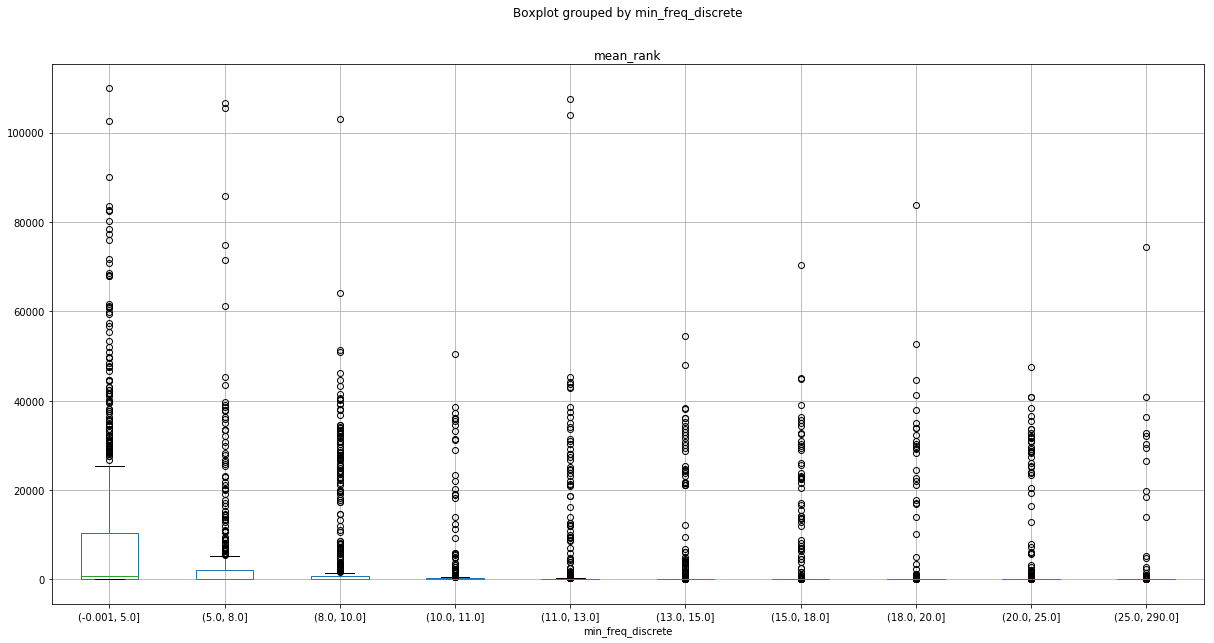

In [37]:
kgpath = "data/YAGO-mapped"
evalfile = "data-to-plot/YAGO3-10_joint/fine_grained_eval.pickle"
master_df = make_boxplot(kgpath, evalfile, 10)

In [38]:
frequency_groups = master_df.groupby(by="min_freq_discrete")
frequency_groups['mean_rank'].describe()

,count,mean,std,min,25%,50%,75%,max
min_freq_discrete,,,,,,,,
"(-0.001, 5.0]",569.0,9991.556239,18383.779771,1.0,32.5,842.5,10475.500,109861.0
"(5.0, 8.0]",501.0,4231.983034,11851.431517,1.0,9.5,157.5,2157.000,106519.5
"(8.0, 10.0]",681.0,3858.870044,10357.611272,1.0,4.0,39.0,639.000,103095.0
"(10.0, 11.0]",312.0,2093.958333,7236.747465,1.0,2.5,13.5,196.375,50334.5
"(11.0, 13.0]",547.0,2499.533821,9620.338569,1.0,3.0,9.0,117.750,107473.5
"(13.0, 15.0]",487.0,2039.932238,7365.172247,1.0,2.0,5.5,49.750,54440.5
"(15.0, 18.0]",590.0,1776.250847,6978.843018,1.0,2.0,5.5,27.500,70331.0
"(18.0, 20.0]",324.0,2345.688272,9012.767034,1.0,2.0,6.0,21.750,83766.5
"(20.0, 25.0]",522.0,1986.164751,7404.997401,1.0,2.0,5.0,16.875,47519.5


### Discussion
It seems like in this dataset too, the trend is similar, although doing worse on more frequent entities hurts the overall results more. Joint is very slightly better for the least frequent 10% of entities in mean rank, and slightly better on the 25% but worse on the median. Otherwise it is doing consistently worse.

# WN18RR

### DistMult only

In [4]:
pickle.load(open("data-to-plot/WN18RR_distmult/valid_results.pickle", "rb"))

{'hits@1': 0.3953526697429466,
 'hits@10': 0.4622610415293672,
 'hits@3': 0.43160843770603163,
 'mrr': 0.41989749309112373}

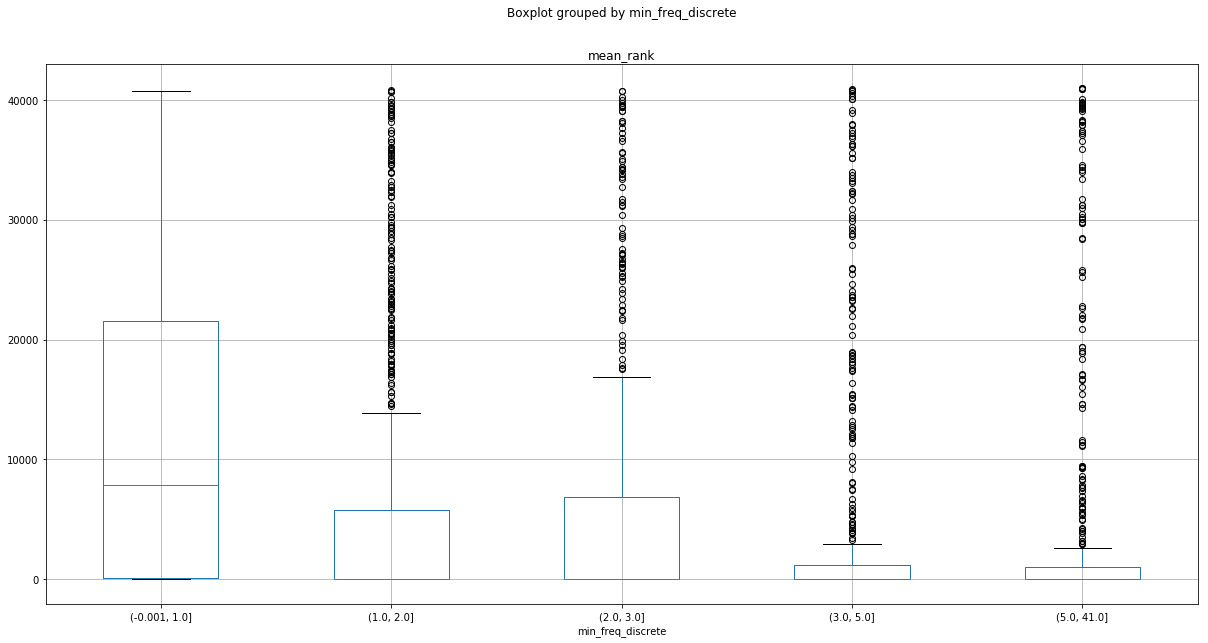

In [7]:
kgpath = "data/WN18RR/mapped"
evalfile = "data-to-plot/WN18RR_distmult/fine_grained_eval.pickle"
master_df = make_boxplot(kgpath, evalfile, 5)

In [8]:
frequency_groups = master_df.groupby(by="min_freq_discrete")
frequency_groups['mean_rank'].describe()

,count,mean,std,min,25%,50%,75%,max
min_freq_discrete,,,,,,,,
"(-0.001, 1.0]",877.0,11428.145952,11881.964982,1.0,117.0,7900.50,21575.500,40680.5
"(1.0, 2.0]",732.0,5854.726093,10906.308929,1.0,1.0,14.75,5745.750,40779.0
"(2.0, 3.0]",388.0,6634.523196,11930.376123,1.0,1.0,24.00,6887.125,40762.0
"(3.0, 5.0]",533.0,4613.327392,10276.590235,1.0,1.0,1.00,1203.500,40867.0
"(5.0, 41.0]",504.0,4571.213294,10600.748735,1.0,1.0,1.00,1069.625,40934.5


### Joint

In [11]:
results = pickle.load(open("data-to-plot/WN18RR_joint/valid_results.pickle", "rb"))
{key:results[key][-1] for key in results}

{'hits@1': 0.38958470665791034,
 'hits@10': 0.4475939353988464,
 'hits@3': 0.4182597231378049,
 'mrr': 0.4103744997421751}

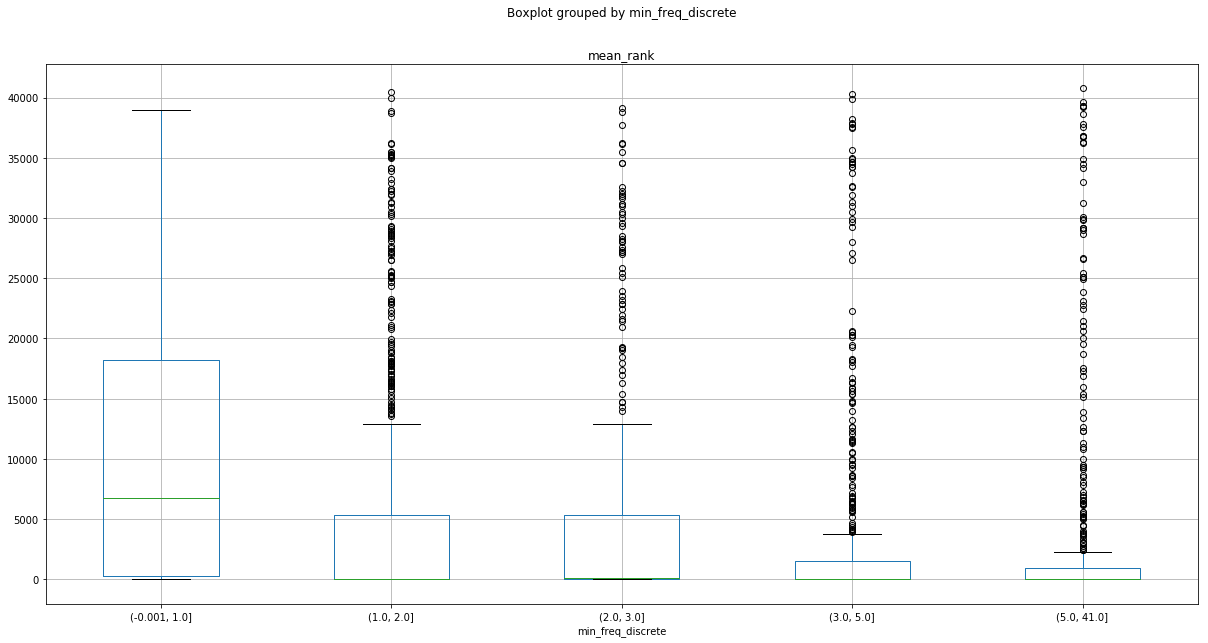

In [13]:
kgpath = "data/WN18RR/mapped"
evalfile = "data-to-plot/WN18RR_joint/fine_grained_eval.pickle"
master_df = make_boxplot(kgpath, evalfile, 5)

In [14]:
frequency_groups = master_df.groupby(by="min_freq_discrete")
frequency_groups['mean_rank'].describe()

,count,mean,std,min,25%,50%,75%,max
min_freq_discrete,,,,,,,,
"(-0.001, 1.0]",877.0,10488.330673,11078.368098,1.0,304.0,6717.50,18200.000,38956.5
"(1.0, 2.0]",732.0,4976.903005,9200.182700,1.0,1.0,48.75,5328.000,40467.0
"(2.0, 3.0]",388.0,5182.177835,9475.733032,1.0,1.0,99.00,5316.875,39154.0
"(3.0, 5.0]",533.0,3484.781426,8300.214863,1.0,1.0,1.00,1547.000,40257.5
"(5.0, 41.0]",504.0,3555.084325,8777.749639,1.0,1.0,1.00,938.125,40760.0


### Discussion
Here the joint model is consistently better in mean rank in all quartiles, and also slightly better in hits@3 and hits@10 in overall measures, but still worse at mrr. This is probably again because while joint training increases the performance for the triples the original model is performing worse in, it does seem to do slightly worse on the best performing ones. (25% for distmult is 117 for the entities that only occur once, but 304 for Joint). It should also be noted that the nature of this dataset is slightly different in that the entities are just meanings of words, so the average entity occurs much more often in the corpus than the other ones. 